<a href="https://colab.research.google.com/github/chuqasmi/recommendation-systems-_GNN-/blob/main/booksrecommd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torch.nn as nn
import random
import pickle
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.2 MB/s eta 0:00:00
Looking in links: ht

Processing...
Done!


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
GCN - Epoch: 001, Loss: 1.9463, Val: 0.1280, Test: 0.1190
GCN - Epoch: 002, Loss: 1.9459, Val: 0.1680, Test: 0.1490
GCN - Epoch: 003, Loss: 1.9454, Val: 0.1880, Test: 0.1730
GCN - Epoch: 004, Loss: 1.9455, Val: 0.2120, Test: 0.1830
GCN - Epoch: 005, Loss: 1.9444, Val: 0.2200, Test: 0.2040
GCN - Epoch: 006, Loss: 1.9442, Val: 0.2340, Test: 0.2200
GCN - Epoch: 007, Loss: 1.9440, Val: 0.2340, Test: 0.2190
GCN - Epoch: 008, Loss: 1.9435, Val: 0.2400, Test: 0.2400
GCN - Epoch: 009, Loss: 1.9431, Val: 0.2660, Test: 0.2550
GCN - Epoch: 010, Loss: 1.9424, Val: 0.2760, Test: 0.2760
GCN - Epoch: 011, Loss: 1.9424, Val: 0.3240, Test: 0.3100
GCN - Epoch: 012, Loss: 1.9423, Val: 0.3480, Test: 0.3640
GCN - Epoch: 013, Loss: 1.9413, Val: 0.3800, Test: 0.3810
GCN - Epoch: 014, Loss: 1.9413, Val: 0.4120, Test: 0.4060
GCN - Epoch: 015, Loss: 1.9408, Val: 0.4400, Test: 0.4410
GCN - Epoch: 016, Loss: 1.9403, Val: 0.4780, Te

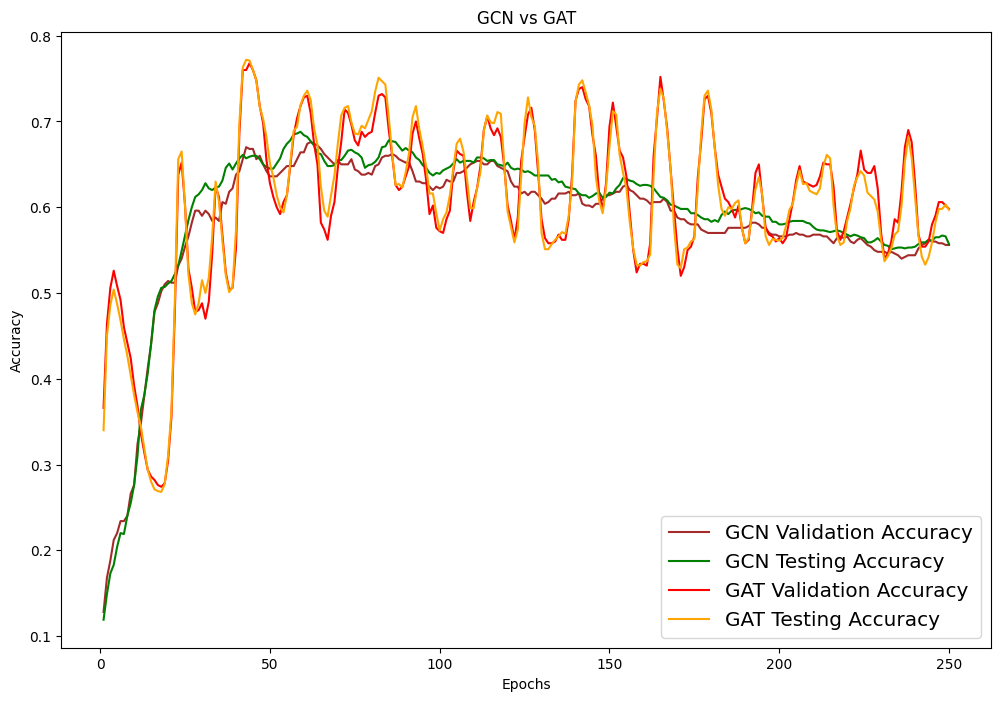

In [1]:
# Install necessary packages
!pip install -q torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F

# Set seed for reproducibility
torch.manual_seed(1234567)

# Load dataset
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=heads)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Visualize function
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Train function for GCN
def train_gcn(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function for GCN
def test_gcn(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

# Train function for GAT
def train_gat(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function for GAT
def test_gat(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

# Instantiate GCN model
gcn_model = GCN(hidden_channels=16)

# Define GCN optimizer and criterion
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=5e-3)
gcn_criterion = torch.nn.CrossEntropyLoss()

# Train GCN
gcn_val_acc_all = []
gcn_test_acc_all = []
for epoch in range(1, 251):
    gcn_loss = train_gcn(gcn_model, gcn_optimizer, gcn_criterion, data)
    gcn_val_acc = test_gcn(gcn_model, data, data.val_mask)
    gcn_test_acc = test_gcn(gcn_model, data, data.test_mask)
    gcn_val_acc_all.append(gcn_val_acc)
    gcn_test_acc_all.append(gcn_test_acc)
    print(f'GCN - Epoch: {epoch:03d}, Loss: {gcn_loss:.4f}, Val: {gcn_val_acc:.4f}, Test: {gcn_test_acc:.4f}')

# Instantiate GAT model
gat_model = GAT(hidden_channels=16, heads=16)

# Define GAT optimizer and criterion
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-3)
gat_criterion = torch.nn.CrossEntropyLoss()

# Train GAT
gat_val_acc_all = []
gat_test_acc_all = []
for epoch in range(1, 251):
    gat_loss = train_gat(gat_model, gat_optimizer, gat_criterion, data)
    gat_val_acc = test_gat(gat_model, data, data.val_mask)
    gat_test_acc = test_gat(gat_model, data, data.test_mask)
    gat_val_acc_all.append(gat_val_acc)
    gat_test_acc_all.append(gat_test_acc)
    print(f'GAT - Epoch: {epoch:03d}, Loss: {gat_loss:.4f}, Val: {gat_val_acc:.4f}, Test: {gat_test_acc:.4f}')

# Plot validation and test accuracies for both models
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(gcn_val_acc_all) + 1), gcn_val_acc_all, label='GCN Validation Accuracy', c='brown')
plt.plot(np.arange(1, len(gcn_test_acc_all) + 1), gcn_test_acc_all, label='GCN Testing Accuracy', c='green')
plt.plot(np.arange(1, len(gat_val_acc_all) + 1), gat_val_acc_all, label='GAT Validation Accuracy', c='red')
plt.plot(np.arange(1, len(gat_test_acc_all) + 1), gat_test_acc_all, label='GAT Testing Accuracy', c='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GCN vs GAT')
plt.legend(loc='lower right', fontsize='x-large')
plt.savefig('gcn_vs_gat_accuracy.png')
plt.show()
